In [2]:
import numpy as np
import pandas as pd
import seaborn as sns


In [3]:
# DESCRIPTION

# The data presents user events from an online cosmetics store for October in 2019
# There are four event types: 'view', 'cart', 'remove-from-cart' and 'purchase'



# DATA

# The data is taken from Kaggle
# https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop



# GOAL

# To conduct a funnel analysis 



# METHODS: 

# To achive the goal the AIDA model is used
# The AIDA model consists of four steps - Attention, Interest, Desire and Action
# For more details read this article: https://amplitude.com/blog/funnel-analysis-in-five-industries
# The data only contains rows for the last three steps
# The 'view' event type is considered as Interest
# The 'cart' event type is considered as Desire
# The 'purchase' event type is considered as Action


In [3]:
data_set = pd.read_csv('2019-Oct.csv')

data_set = data_set.iloc[:,[0,1,2,7,8]]

data_set = data_set[data_set.iloc[:,4].notnull()]


In [160]:
# ASSUMPTIONS (1)


# Here you can see the assumptions based on which the code below is written.
# Some of them are taken because of the lack of information about how the website actually works

# 1) - The store is a typical website with the search bar for selling different items which has the main page and seperate 
# pages for all products

# 2) - A session ID is changed every time a user comes back to the store after a long pause

# 3) - To purchase an item users usually need to go through this path - view the item page, then add an item to the shopping 
# cart and buy it after getting on the shopping cart page.

# 4) - Using this piece of code you can see that the items added to the shopping cart in the previous sessions are saved in 
# the following ones so that the user journey is decreased and additional items can be added and bought without viewing them 
# just from the shopping cart.

data_set['event_time'] = pd.to_datetime(data_set['event_time'])

data_set[data_set['event_time'].map(lambda x: x.day) > 10].drop_duplicates(['user_session']).head(50)


In [4]:
# ASSUMPTIONS (2)


# 5) - It's also possible that in addition to the button to add an item to the shopping cart an item page can have the button 
# to purchase an item directly from that page. It's another decreased user journey to utilize by users.

# 6) - In each session user events can be related to different products. For this reason in one session all different types of
# events are counted one time per product if happened.
#
# (If a user adds an item to the cart and then remove the item from it, this ation will be counted as 'cart'. And if 
# a user either browses a page, adds an item to the cart or purchases an item more than one time for the same product, each 
# event will be calculated only once.)
#
# It means the rows with the event type 'remove_from_cart' are not important for calculations


# Getting the data without the rows with the event type 'remove_from_cart'

data_set = data_set[data_set['event_type'] != 'remove_from_cart']

data_set.index = range(len(data_set))


In [16]:

# Next you can see three different ways to get results
# They are ordered by the time necessary to calculate results
# The less time consuming way is to use a PIVOT TABLE 
# The more time consuming way is just to use basic FOR loops

# The time for computing statistics by using these three ways for only 10000 rows are 119 ms, 678 ms and 5.77 s.
# The use of a pivot_table method from pandas is almost 48.5 times faster than for loops.


In [42]:
%%time

data_for_pivot = data_set.iloc[:,[1,2,4]].copy()

data_for_pivot['event_types'] = data_set.iloc[:,1]



funnel_data = data_for_pivot \
.pivot_table('event_type', index = ['user_session','product_id'], columns = 'event_types', aggfunc = 'nunique').sum()


Wall time: 12.5 s


<AxesSubplot:>

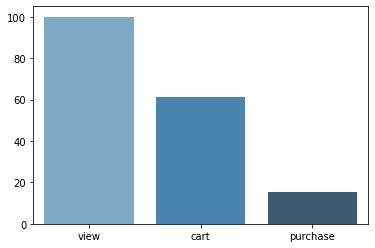

In [43]:
funnel_data = funnel_data[['view','cart','purchase']]

funnel_data = funnel_data.map(lambda x: int(x))

funnel_data.index.name = ''

funnel_data = funnel_data / funnel_data[0] * 100


sns.barplot(x = funnel_data.index, y = funnel_data.values, palette="Blues_d")


In [31]:
# You can see a drop-off between the 'cart' bar and the 'purchase' bar

# Computing how much the drop-off is by dividing the rate between the 'view' and the 'cart' bars by the rate between the 'cart' 
# and the 'purchase' bars

# The rate between 'cart' and 'purchase' events is 2.46 times less

(funnel_data[1] / funnel_data[0]) / (funnel_data[2] / funnel_data[1])

2.461215745280437

In [ ]:
# BE CAREFUL TO RUN THIS CODE FOR ALL ROWS! IT CAN TAKE MUCH TIME!

In [13]:
%%time

d = data_set.iloc[:10000,[1,2,4]]

g = d['event_type'].groupby([d['user_session'],d['product_id']])


event_names = pd.Series(['view','cart','purchase'])



def f(x):
    
    global event_name
    
    indicator = 0

    if event_name in x.values:
        
        indicator = 1
    
    return indicator



for i in range(3):
    
    event_name = event_names[i]
    
    if i == 0:
        
        first = g.agg(f)
        
    else:
        
        first = pd.concat([first,g.agg(f)], axis = 1)
        
first.columns = ['view','cart','purchase']
        
first.sum()

Wall time: 678 ms


view        3751
cart        2546
purchase     822
dtype: int64

In [ ]:
# BE CAREFUL TO RUN THIS CODE FOR ALL ROWS! IT CAN TAKE MUCH TIME!

In [14]:
%%time

d = data_set[:10000]

product_ids = pd.Series(d['product_id'])

product_ids.index = d['user_session']



event_types = pd.Series(d['event_type'])

event_types.index = d['user_session'] 



user_sessions = pd.Series(event_types.index.unique())



t_view = 0

t_cart = 0

t_purchase = 0


series_type = type(event_types)


for i in range(len(user_sessions)):
    
    
    if type(event_types[user_sessions[i]]) == series_type:
        
        session_events = event_types[user_sessions[i]]
        
        session_products = product_ids[user_sessions[i]]
        
    else:
        
        session_events = pd.Series(event_types[user_sessions[i]])
        
        session_events.index = [user_sessions[i]]
        
        session_products = pd.Series(product_ids[user_sessions[i]])
        
        session_products.index = [user_sessions[i]]
    
    
    uni_sess_products = pd.Series(session_products.unique())

    
    for j in range(len(uni_sess_products)):
        
        
        product_events = session_events[session_products == uni_sess_products[j]]
        
        if 'view' in product_events.values:
            
            t_view = t_view + 1
            
        if 'cart' in product_events.values:
            
            t_cart = t_cart + 1
            
        if 'purchase' in product_events.values:
            
            t_purchase = t_purchase + 1
            
print(t_view, t_cart, t_purchase)


3751 2546 822
Wall time: 5.77 s
